In [50]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time

import numpy as np
import matplotlib.pyplot as plt

import sys, os

import moyra as ma
import moyra.elements as ele
import moyra.forces as ef

me.mechanics_printing()

#### Create Symbols

In [51]:
from sympy.abc import x,y,z
DoFs = 2          # total degrees of freedom

p = ma.DynamicModelParameters(DoFs)
p.L = ma.ModelSymbol(string = 'L')
p.m = ma.ModelSymbol(string = 'm')
p.Fx = ma.ModelSymbol(string = 'Fx')
p.Fy = ma.ModelSymbol(string = 'Fy')
p.Fz = ma.ModelSymbol(string = 'Fz')
p.K = ma.ModelSymbol(string = 'K')

# Attitude Parmas
p.rho = ma.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = ma.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha  = ma.ModelSymbol(value = 0,string = 'alpha')                     # gravity


#### Create Coordinate Systems

In [53]:
tether_frame = ma.HomogenousTransform().R_z(p.q[0]).R_x(p.q[1]).Translate(0,0,-p.L)

#Generate Mass Matrices
# M = ele.MassMatrix(p.m, I_xx = p.I_xx, I_yy=p.I_yy, I_zz=p.I_zz)
M = ele.MassMatrix(p.m, I_xx = 0, I_yy=0, I_zz=0)

# Generate Rigid Elements
aircraft_mass = ele.RigidElement(tether_frame,M,gravityPotential=True)
#tether_spring = ele.Spring(p.q[2],p.K)

# Generate Aircraft Forces
aircraft_forces = ef.BodyForce(p,tether_frame,Fx=p.Fx,Fy=p.Fy,Fz=p.Fz)

In [54]:
sm = ma.SymbolicModel.FromElementsAndForces(p,[aircraft_mass],ExtForces=aircraft_forces)

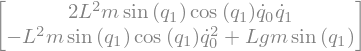

In [55]:
sm.f

In [56]:
test = sym.simplify(aircraft_forces._trigsimp(tether_frame.BodyJacobian(p.q)))

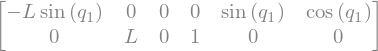

In [57]:
import sympy

# A = U S V'

if test.shape[0] <= test.shape[1]:
    A1 = test * test.T
    U, S = A1.diagonalize(normalize=True)
    V = (S**-1 * U.T * test).T
else:
    A2 = test.T * test
    V, S = A2.diagonalize(normalize=True)
    U = test * V * S**-1

V * S.T * U.T 

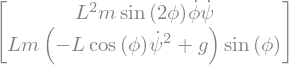

In [58]:
psi = me.dynamicsymbols('psi')
phi = me.dynamicsymbols('phi')
sym.simplify(sm.f).subs({p.q[0]:psi,p.q[1]:phi})

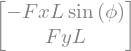

In [59]:
sm.ExtForces.Q().subs({p.q[0]:psi,p.q[1]:phi})

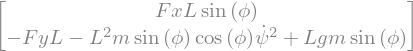

In [60]:
A = (sm.M*p.qdd+sm.f-sm.ExtForces.Q()).subs({**{i:0 for i in p.qdd},p.qd[1]:0})
ae = A.subs({p.q[0]:psi,p.q[1]:phi})
ae

In [61]:
ae = ae.subs({p.Fy:sym.Rational(1,2)*p.rho*p.V**2*p.alpha})

In [62]:
V = sym.Symbol('V')
A_new = me.msubs(A[1],{p.qd[0]:V/(p.L*sym.sin(p.q[1]))})
A_new = A_new.subs({p.q[0]:psi,p.q[1]:phi})

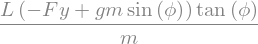

In [63]:
V_2 = sym.solve(A_new,V**2)[0]
sym.simplify(V_2.subs({p.q[0]:psi,p.q[1]:phi}))

In [80]:
tether_frame = ma.HomogenousTransform().R_z(p.q[0]).R_x(p.q[1]).Translate(0,0,-p.L)
V_body = sym.simplify(tether_frame.Translate(x,y,z).BodyVelocity())

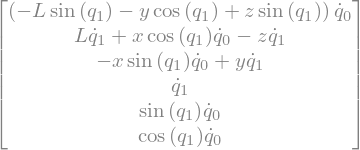

In [81]:
V_body

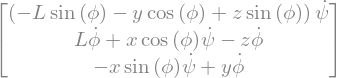

In [85]:
vb = sym.Matrix(V_body[0:3])
#vb = me.msubs(vb,{p.qd[0]:V/(p.L*sym.sin(p.q[1])),p.qd[1]:0})
vb = vb.subs({p.q[0]:psi,p.q[1]:phi})
vb

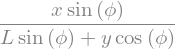

In [92]:
sym.simplify(V_body[2]/V_body[0]).subs({p.q[0]:psi,p.q[1]:phi})

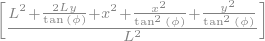

In [95]:
sym.simplify(V_body.T*V_body/V**2).subs({p.q[0]:psi,p.q[1]:phi})

In [75]:
test_frame = ma.HomogenousTransform().R_z(p.q[0]).R_x(p.q[1]).Translate(0,0,-p.L)

In [76]:
V_body = sym.simplify(test_frame.Translate(x,y,z).BodyVelocity())

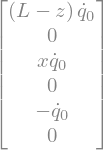

In [79]:
sym.simplify(V_body.subs({p.q[1]:sym.pi/2}))

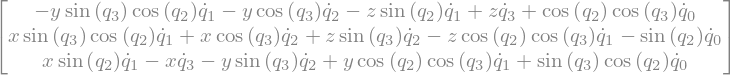

In [90]:
from sympy.abc import x,y,z
from sympy.abc import psi,phi,mu,beta,alpha,theta
p = ma.DynamicModelParameters(4)
body_frame = ma.HomogenousTransform().R_x(sym.pi).Translate(p.q[0],0,0).R_x(p.q[1]).R_z(p.q[2]).R_y(p.q[3])
V_body = sym.simplify(body_frame.Translate(x,y,z).BodyVelocity())
vb = sym.Matrix(V_body[0:3])


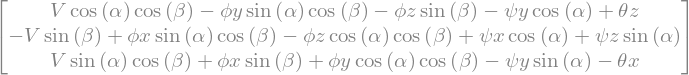

In [99]:
vb_new = me.msubs(vb,{p.q[0]:0,p.q[1]:mu,p.q[2]:beta,p.q[3]:alpha,p.qd[0]:V,p.qd[1]:phi,p.qd[2]:psi,p.qd[3]:theta})
vb_new

In [114]:
file_dir = "C:\\Users\\qe19391\\OneDrive - University of Bristol\\Desktop\\"
to_matlab_file(vb_new,'FreeFlight',file_dir)

In [111]:
from time import time, ctime
def gen_octave(expr,func_name):
        # get parameter replacements
        matries = []

        # split expr into groups
        replacments, exprs = sym.cse(expr,symbols=(sym.Symbol(f'rep_{i}')for i in range(10000)))
        if isinstance(expr,tuple):
            expr = tuple(exprs)
        elif isinstance(expr,list):
            expr = exprs
        else:
            expr = exprs[0]      

        group_string = '%% create common groups\n\t'
        for variable, expression in replacments:
            group_string +=f'{variable} = {sym.printing.octave.octave_code(expression)};\n\t'
        
        # convert to octave string and covert states to vector form
        out = '%% create output vector\n\tout = ' + sym.printing.octave.octave_code(expr)

        # make the file pretty...
        out = out.replace(',',',...\n\t\t').replace(';',';...\n\t\t')

        file_sig = f'%{func_name.upper()} Auto-generated function from python\n\t'
        file_sig += f'%\n\t'
        file_sig += f'%\tCreated at : {ctime(time())} \n\t'
        file_sig += f'%\tCreated with : moyra https://pypi.org/project/moyra/\n\t'
        file_sig += f'%\n\t'


        # wrap output in octave function signature
        signature = f'function out = {func_name}()\n\t'
        octave_string = signature + file_sig + group_string + out + ';\nend'
        return octave_string
def to_matlab_file(expr,func_name,file_dir):
    with open(file_dir+f"{func_name}.m",'w') as file:
        file.write(gen_octave(expr,func_name))